In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import geopandas as gpd
import pandas as pd
import rasterio
from rasterio.plot import show
import xarray as xr
import rioxarray as rxr
from shapely import Point, MultiPoint, wkt
import regex as re
import json
from matplotlib.colors import ListedColormap, BoundaryNorm
import pickle

# General Weather Plots

We begin by loading the forecast deviation dataframe as produced in the data_preparation notebook. Recall that this dataframe consists of the following:

- Index:
    - Location, (city name) 
    - Type, (high or low)
    - Date, (date to be forecast)

- Columns: Integers representing how many days in advance the forecast is from.
- Data: Values representing the deviation between the forecast and the true value.

As an example, in the below snippet we see the value for Abidjan, high, 2020-07-25 in column 3 is -2. This means that for the forecast recorded on 2020-07-22, the high temperture was 2 degrees lower than the actual high temperature eventually observed.

In [2]:
with open('data/forecast_dev_df.pkl','rb') as f:
    forecast_dev_df = pickle.load(f)

forecast_dev_df.head()

0    1    2    3    4   5   6   7   8   9   ...  \
Location Type Date                                                     ...   
Abidjan  high 2020-07-22  1.0  NaN  NaN  NaN  NaN NaN NaN NaN NaN NaN  ...   
              2020-07-23  0.0 -1.0  NaN  NaN  NaN NaN NaN NaN NaN NaN  ...   
              2020-07-24 -1.0  0.0  0.0  NaN  NaN NaN NaN NaN NaN NaN  ...   
              2020-07-25 -1.0 -2.0 -2.0 -2.0  NaN NaN NaN NaN NaN NaN  ...   
              2020-07-26  0.0  0.0 -1.0 -1.0 -1.0 NaN NaN NaN NaN NaN  ...   

                          21  22  23  24  25  26  27  28  29  30  
Location Type Date                                                
Abidjan  high 2020-07-22 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
              2020-07-23 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
              2020-07-24 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
              2020-07-25 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
              2020-07-26 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  

[5 rows x 31 columns]

We take the absolute deviation as a measure of error. We produce some summaries for this

In [3]:
abs_forecast_dev_df = np.abs(forecast_dev_df)
mean_abs_forecast_dev_df = abs_forecast_dev_df.groupby(level=[0,2]).mean() # Mean over hi/lo temp deviations.
abs_summaries = abs_forecast_dev_df.describe()

The simplest plots we can do are plots of the mean absolute error and the standard deviation of the absolute error.

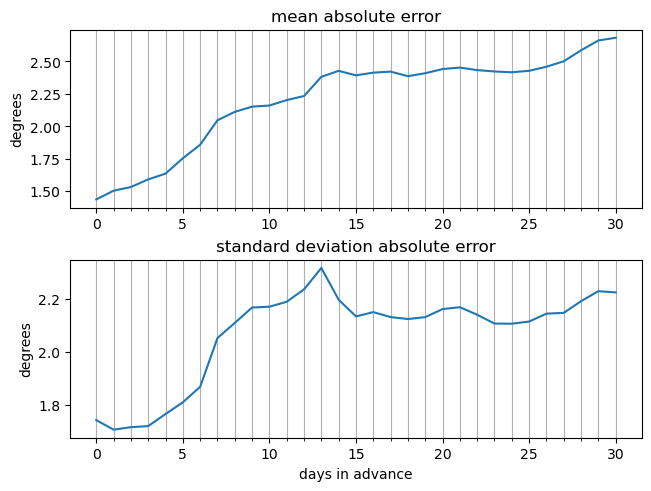

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, constrained_layout=True)

ax1.plot(abs_summaries.loc['mean'])
ax1.set_title('mean absolute error')
ax1.set_xticks(np.linspace(0,30,31), minor=True)
ax1.grid(which='both',axis='x')


ax2.plot(abs_summaries.loc['std'])
ax2.set_title('standard deviation absolute error')
ax2.set_xticks(np.linspace(0,30,31), minor=True)
ax2.grid(which='both',axis='x')

plt.setp(ax2, xlabel='days in advance')
plt.setp(ax1, ylabel='degrees')
plt.setp(ax2, ylabel='degrees')
plt.show()

The mean absolute deviation gives roughly the expected result, although it's worth noting that it is quite flat between days 14-26, before rising a bit again. The standard deviation seems to give a more interesting result, rising shraply until day 13, and then dropping sharply afterwards, once the two-weeks-in-advance boundary is reached.

Next, we can check how the high and low prediction vary, out of curiosity.

In [5]:
abs_summaries_hi = np.abs(abs_forecast_dev_df.xs('high', level=1)).describe()
abs_summaries_lo = np.abs(abs_forecast_dev_df.xs('low', level=1)).describe()

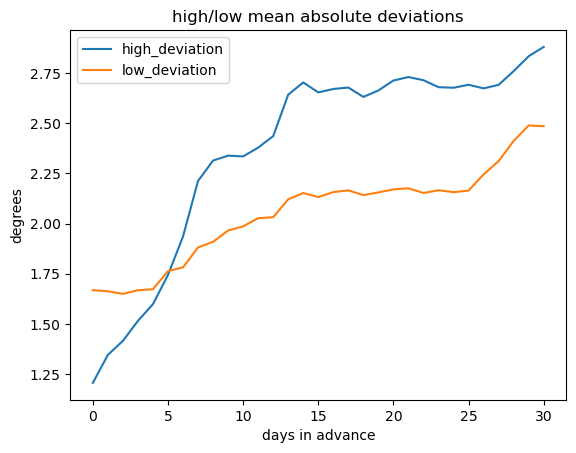

In [6]:
plt.plot(abs_summaries_hi.loc['mean'], label='high_deviation')
plt.plot(abs_summaries_lo.loc['mean'], label='low_deviation')
plt.xlabel('days in advance')
plt.ylabel('degrees')
plt.title('high/low mean absolute deviations')
plt.legend()
plt.show()


There is an interesting effect here, where the temperature highs appear more difficult to predict than the temperature lows ordinarily, but in the short-term the opposite effect holds. It would be interesting to investigate if this is due to some insufficiency in the data or some other reason. Overall, they follow similar trends, though at apparently slightly different gradients, nevertheless I will make the decision to continue to use both high and low predictions for the rest of the notebook for the sake of simplicity and conciseness.

We can then check a rather different metric of the number of sites falling within a threshold error. It is important to take this quantity as a ratio to the total number of measurements, as the number of readings fall off as we look further in advance due to the limited data collection period.

In [7]:
def percentage_within_deg(degree_threshold):
    total_within_threshold = (abs_forecast_dev_df<=degree_threshold).sum()
    total_readings = abs_forecast_dev_df.count()

    return total_within_threshold/total_readings

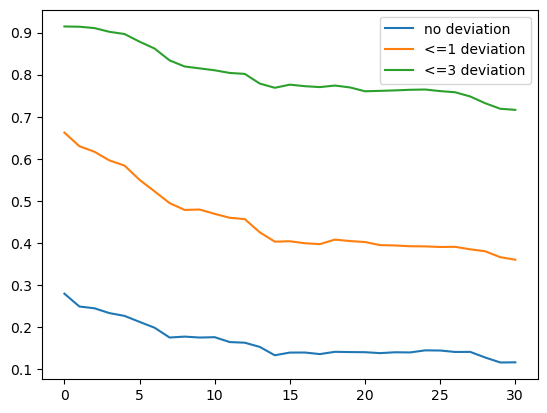

In [8]:
plt.plot(percentage_within_deg(0), label='no deviation')
plt.plot(percentage_within_deg(1), label='<=1 deviation')
plt.plot(percentage_within_deg(3), label='<=3 deviation')
plt.legend()
plt.show()

These plots continue to show a very interesting trend, similar to that observed with the standard deviation plot: until around the two week mark, the error is clearly descending, but after that point, the error more-or-less plateaus. I would wager that a model switch occurs around the two week mark, and one which relies more on historical data replaces the one based on weather data. As a future part of this project I would like to see if it is possible to match their beyond-two-week forecasts using simple models based purely on historical data.

There is also a question of if a second model switch occurs, around the 26-28 day mark, where there is another visible change in the plot. I would guess that in this case, we might just be dealing with an insufficiency of the data, or perhaps a large weather phenomenon which could not have been easily predicted. 

The reason I believe that this is the case is that the first change at around 13-14 days occurs at a point which *improves* upon where the error would be if it followed the trend up to that point, whereas with the second change there is a degradation, so switching to a worse model would not make sense.

# Additional City Data

Given the data we've collected, we can ask additional questions relating to geographic and economic information such as:

- How does global climate region affect weather predictability
- How does country GDP per capita affect predictability? 

 Ideally, we would have cross-seasonal data for these questions, but we don't. Hopefully this can be done for a future project. We begin by import the location, climate and gdp data. The climate data consists of the Koppen-Geiger climate classification for each city and the GDP is the PPP-adjusted GDP per capita for each country to which the cities belong.

In [9]:
with open('data/city_info.csv', 'r') as f:
    city_info_df= pd.read_csv(f)
    city_info_df = city_info_df.set_index('Location')
    city_info_df['Lat/Lon'] = city_info_df['Lat/Lon'].apply(wkt.loads)
    city_info_gdf = gpd.GeoDataFrame(
    city_info_df, geometry='Lat/Lon', crs="EPSG:4326"
)

We can then join the forecast deviation data to the climate and economic data for the cities.

In [10]:
city_weather_info_df = forecast_dev_df.join(city_info_df).drop('Country', axis=1)
city_weather_info_gdf = gpd.GeoDataFrame(
    city_weather_info_df, geometry='Lat/Lon', crs="EPSG:4326"
)

Let's view the geographic distribution of Accuweather's top 150 cities.

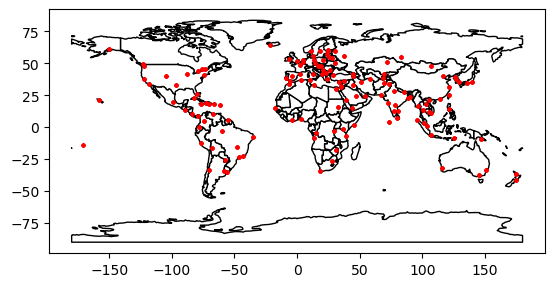

In [11]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
base = world.plot(color='white', edgecolor='black')
city_weather_info_gdf.plot(ax=base, marker='o', color='red', markersize=2);

We can see that they are quite well-distributed globally but there are some shortcomings for our purposes.
- Europe is overrepresented.
- North Africa is underrepresented (arguably Africa is a whole is). 
- China appears to have very little representation for its population, with no cities in central China. 
- Far northern climes are also not well-represented, but they are also presumably not well-populated so this might by why.

Any future work could aim to ensure a more representative distribution of cities, primarily by taking a few out of the densely represented Europe.

We continue by taking the absolute values of the deviations.

In [12]:
city_weather_info_abs = city_weather_info_gdf.copy()
city_weather_info_abs.iloc[:,:31] = np.abs(city_weather_info_gdf.iloc[:,:31])

Below we consider two groupings for the data 
1. A northern, southern and equatorial grouping. Given the time of year at which the data was collected, this coincides with summer, winter and equatorial.
2. Main climate type. The Koppen Geiger classification consists of types and subtypes. In order to have a statistically significant number of locations for each climate we coarse grain the data to consider just the primary types

In [13]:
def latitude_mapping(point):
    latitude = point.coords[0][1]
    if latitude > 10:
        return 'northern'
    elif latitude < -10:
        return 'southern'
    else:
        return 'equatorial'
    
    
def main_climate_mapping(climate_num): # Mapping from legend.txt
    if climate_num in range(1,4):
        return 'A'
    elif climate_num in range(4,8):
        return 'B'
    elif climate_num in range(8,17):
        return 'C'
    elif climate_num in range(17,29):
        return 'D'
    elif climate_num in range(29,31):
        return 'E'



In [14]:
latitude_abs_df = city_weather_info_abs.reset_index().set_index('Lat/Lon').groupby(latitude_mapping)
mean_latitude_abs_df = latitude_abs_df.mean().iloc[:,:31]

climate_abs_df = city_weather_info_abs.reset_index().set_index('Climate').groupby(main_climate_mapping)
mean_climate_abs_df = climate_abs_df.mean().iloc[:,:31]

C:\Users\Sammy\AppData\Local\Temp\ipykernel_29032\2503664849.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_latitude_abs_df = latitude_abs_df.mean().iloc[:,:31]
C:\Users\Sammy\AppData\Local\Temp\ipykernel_29032\2503664849.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_climate_abs_df = climate_abs_df.mean().iloc[:,:31]


We can check the north, south, equatorial divide first

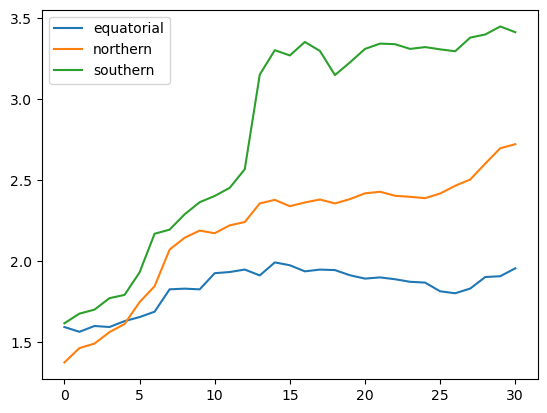

In [15]:
plt.plot(mean_latitude_abs_df.loc['equatorial'], label='equatorial')
plt.plot(mean_latitude_abs_df.loc['northern'], label='northern')
plt.plot(mean_latitude_abs_df.loc['southern'], label='southern')
plt.legend()
plt.show()

This plot suggests that the uptick at around 25-30 degrees is more pronounced in northern climes, which supports the idea that it could just be a deviation caused by an extreme weather phenomenon. We can also check the climate division. This reveals that some climates are much easier to predict than others.

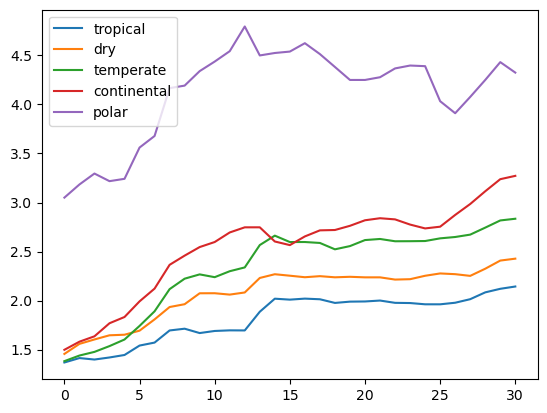

In [16]:
plt.plot(mean_climate_abs_df.loc['A'], label = 'tropical')
plt.plot(mean_climate_abs_df.loc['B'], label = 'dry')
plt.plot(mean_climate_abs_df.loc['C'], label = 'temperate')
plt.plot(mean_climate_abs_df.loc['D'], label = 'continental')
plt.plot(mean_climate_abs_df.loc['E'], label = 'polar')
plt.legend()
plt.show()

## Economic effects

As motivation, lets look at where accuweather source their data. From [accuweather's website](https://corporate.accuweather.com/company/weather-matters/),

> We collect the most complete database of forecast models from around the world. We source weather data from governments and partners; observations from land, ships, and aircraft; crowdsourced reports; satellites; and radar sets from 40 countries.

The data collection process gives some clues as to how economic factors could influence weather prediction:

- Different types of data may be available, which could impact what models are applicable.
- There may be fewer data points for a given type of data (e.g. crowdsourced reports).
- There may be sensor errors, or errors in data entry and transmission if some places have lower capacity to vet the data.

In [17]:
def gdp_quantile(dollar_amount):
    quantile_bounds = np.quantile(city_weather_info_abs['GDP per capita (PPP)'], [0.33,0.67,1])
    position = np.searchsorted(quantile_bounds, dollar_amount)
    return np.round((1+position)*0.333,2)

gdp_abs_df = city_weather_info_abs.reset_index().set_index('GDP per capita (PPP)').groupby(gdp_quantile)
mean_gdp_abs_df = gdp_abs_df.mean().iloc[:,:31]

C:\Users\Sammy\AppData\Local\Temp\ipykernel_29032\643143597.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_gdp_abs_df = gdp_abs_df.mean().iloc[:,:31]


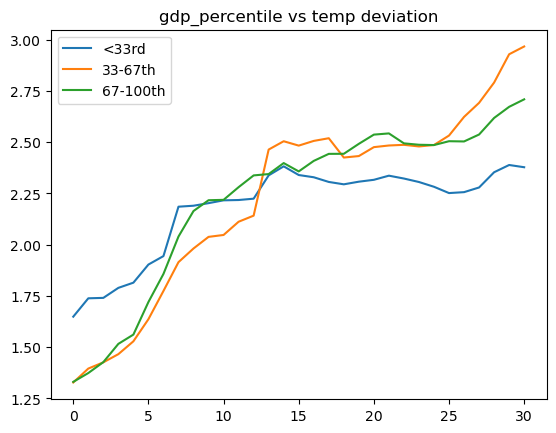

In [18]:
plt.plot(mean_gdp_abs_df.iloc[0,:], label='<33rd')
plt.plot(mean_gdp_abs_df.iloc[1,:], label='33-67th')
plt.plot(mean_gdp_abs_df.iloc[2,:], label='67-100th')
plt.title('gdp_percentile vs temp deviation')
plt.legend()
plt.show()

The first thing of note here is that the lower GDP regions appear to be easier to predict in the long-term. I suggest that this is due to the larger representation of equatorial countries in places with lower GDP, as indicated below.

In [19]:
latitude_abs_df['GDP per capita (PPP)'].mean()

Lat/Lon
equatorial    14933.884298
northern      30348.083690
southern      23691.603053
Name: GDP per capita (PPP), dtype: float64

We can visualise this on the map. The red locations below are in the lower-third of nations by GDP and there is a very stark tropical tendency in comparison to the nations in the upper two-thirds.

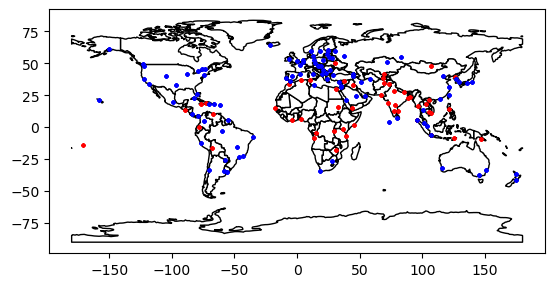

In [20]:
third_quantile_bound = max(gdp_abs_df.groups[0.33])
third_quantile_locations = city_weather_info_abs[city_weather_info_abs['GDP per capita (PPP)']<=third_quantile_bound]
remaining_locations = city_weather_info_abs[city_weather_info_abs['GDP per capita (PPP)']>=third_quantile_bound]
base = world.plot(color='white', edgecolor='black')
third_quantile_locations.plot(ax=base, marker='o', color='red', markersize=2)
remaining_locations.plot(ax=base, marker='o', color='blue', markersize=2);

My data indicates that equatorial/tropical regions have more easily predictable temperatures, and this observation is supported by [the literature](https://www.nature.com/scitable/knowledge/library/tropical-weather-84224797/#:~:text=There%20are%20no%20fronts%20in,tropical%20temperature%20is%20quite%20predictable). Hence, we've showed that countries with lower GDPs bias equatorial which should make their temperatures predictable.

Despite being in-principle easier to predict, the short-term predictions are noticeably worse for these countries and I want to investigate the prevalance of clear errors in these predictions.

We can do this by investigating the 'next day' deviations; that is, how far off is the weather forecast for the very next day. The rationale for this quantity, is that the next day forecast being far off is likely to indicate things such as errors in recording data (even simple data entry) or errors in weather sensor data (if these are not protected against).

In [21]:
def day_before_error_ratios(degrees_off):

    day_before_errors_df = city_weather_info_abs[city_weather_info_abs[1]>=degrees_off]
    day_before_errors_count = day_before_errors_df.reset_index().set_index('GDP per capita (PPP)')
    day_before_errors_count = day_before_errors_count.groupby(gdp_quantile)
    day_before_errors_count = day_before_errors_count.count()[1]
    readings_per_gdp_count = gdp_abs_df.count()[1]

    return day_before_errors_count/readings_per_gdp_count

In [22]:
big_errors_by_gdp = pd.concat((day_before_error_ratios(i) for i in range(5,11)), axis=1)
big_errors_by_gdp.columns = range(5,11)

We can collect all this in the below plot, where we view the next-day errors where countries are sorted by GDP. The lower third of countries very clearly have a substantially higher ratio of errors for the next-day forecasts. The error threshold below indicates the amount of deviation after which we consider an error to have occurred.

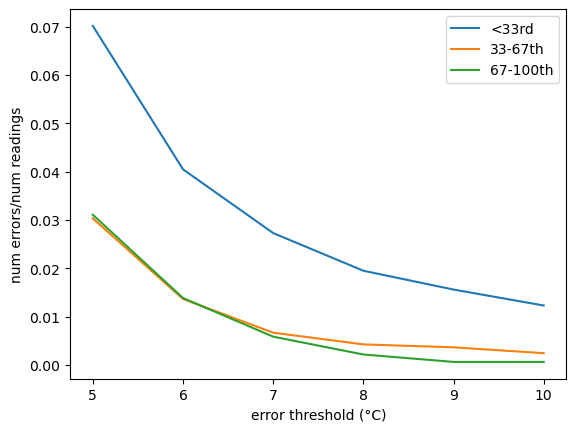

In [26]:
plt.plot(big_errors_by_gdp.iloc[0], label='<33rd')
plt.plot(big_errors_by_gdp.iloc[1], label='33-67th')
plt.plot(big_errors_by_gdp.iloc[2], label='67-100th')
plt.xlabel('error threshold (°C)')
plt.ylabel('num errors/num readings')
plt.legend()
plt.show()